# Reward and Error Learning Simulation (Izawa & Shadmehr, 2011)

## 1. Imports and Constants

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Simulation settings
n_trials = 200
gamma = 0.9           # discount factor
alpha_r = 0.1         # learning rate for reward prediction error
alpha_v = 0.1         # learning rate for value function
a = 0.98              # forgetting factor for perturbation
b = np.array([[0], [1]])  # input matrix
C = np.array([[1, 1]])    # observation matrix
A = np.array([[a, 0], [1, 0]])

# Noise terms
s_h = 0.1
s_y_by_condition = {
    "ERR": 5.0,
    "EPE": 20.0,
    "RWD": 1e6  # essentially no observation
}
s_phat = 0.1
s_u = 0.1

target_radius = 3
beta = 0.1 # Scaling parameter for motor cost

Q = np.diag([s_phat**2, s_h**2])

# Initial values
x = np.zeros((2, 1))    # true state: [p; h]
x_hat = np.zeros((2, 1)) # state estimate
w_r = 0.0                # reward-based controller
w_v = 0.0                # value estimate
nu = 0.0                 # motor noise

## 2. Task Environment Setup

In [ ]:
def simulate(condition="ERR", seed=42):
    np.random.seed(seed)
    # Visual noise level varies by condition
    s_y = s_y_by_condition[condition]

    x = np.zeros((2, 1))     # Initialize true state [p; h]
    x_hat = np.zeros((2, 1)) # Initialize state estimate
    P = Q
    
    w_r = 0.0
    w_v = 0.0

    h_history = []
    h_hat_history = []

    for k in range(n_trials):
        # Noise terms
        n_h = np.random.normal(0, s_h)
        n_y = np.random.normal(0, s_y)
        n_p = np.random.normal(0, s_phat)
        n_u = np.random.normal(0, s_u)

        n_x = [[n_h], [n_p]]

        y = C @ x + n_y  # observation with noise
        u = -x_hat[0] + w_r + n_u

        x_hat_kk1 = A @ x_hat + b @ u_k
        P_kk1 = A @ P @ A.T + Q
        K = P_kk1 @ C.T @ np.linalg.inv(C @ P_kk1 @ C.T + s_y**2)
        P_kk = (np.eye(2) - K @ C) @ P_kk1

        x_hat_kk = x_hat_kk1 + K @ (y - C @ x_hat_kk1)  # Kalman update

        P = P_kk
        x_hat = x_hat_kk


        x = A @ x + b * u + n_x  # true state update
        err = C @ x  # hand error: c = p + h
    
        # reward computation
        in_target = np.abs(err) < target_radius
        effort = beta*u**2
        reward = 1 - effort if in_target else -effort
        delta_r = reward + gamma * w_v - w_v
        w_v += alpha_v * delta_r
        w_r += alpha_r * delta_r * n_u



        p = a * x[0, 0] + np.random.normal(0, Q[0, 0]**0.5)
        u = -p_hat + w_r + np.random.normal(0, 0.5)  # control policy
        h = u + np.random.normal(0, Q[1, 1]**0.5)
        x = np.array([[p], [h]])

        y = C @ x + np.random.normal(0, R**0.5, size=(1, 1))

        # Kalman prediction
        x_hat = A @ x_hat + b * u
        P = A @ P @ A.T + Q

        # Kalman update
        K = P @ C.T @ np.linalg.inv(C @ P @ C.T + R)
        x_hat = x_hat + K @ (y - C @ x_hat)
        P = (np.eye(2) - K @ C) @ P


        h_history.append(h)
        h_hat_history.append(x_hat[1, 0])
        p_hat = x_hat[0, 0]

    return np.array(h_history), np.array(h_hat_history)


## 3. Run Simulation for Each Condition

In [5]:
conditions = ["ERR", "EPE", "RWD"]
results = {}

for cond in conditions:
    h, h_hat = simulate(cond)
    results[cond] = (h, h_hat)

## 4. Plotting Estimated vs Actual Hand Position

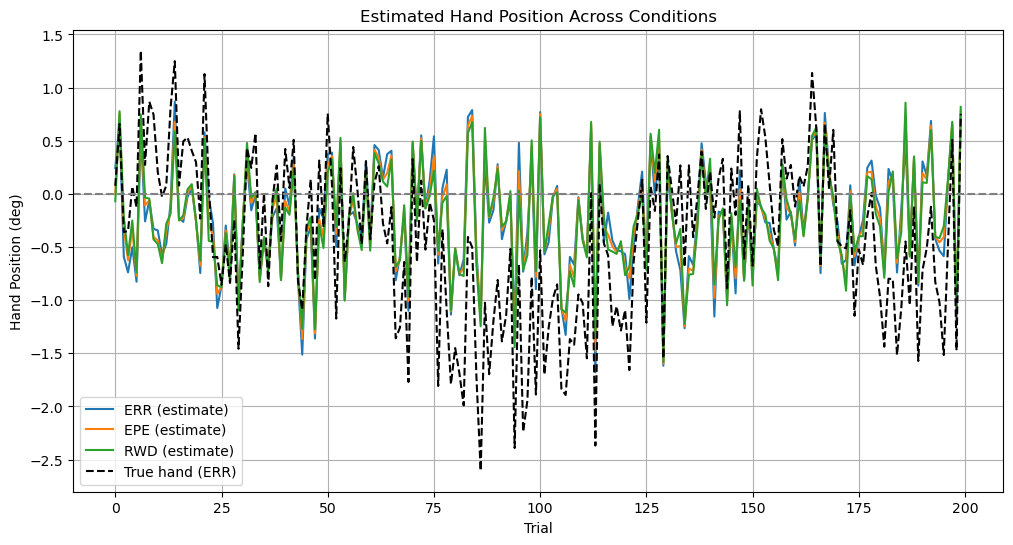

In [6]:
plt.figure(figsize=(12, 6))
for cond, (h, h_hat) in results.items():
    plt.plot(h_hat, label=f"{cond} (estimate)")
plt.plot(results["ERR"][0], '--', color='k', label="True hand (ERR)")
plt.axhline(0, color='gray', linestyle='--')
plt.title("Estimated Hand Position Across Conditions")
plt.xlabel("Trial")
plt.ylabel("Hand Position (deg)")
plt.legend()
plt.grid(True)
plt.show()